In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import batman
from astropy.io import fits
import spiderman as sp
from astropy import units as u
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook


import sys
sys.path.insert(1, '/Users/bob/Documents/PhD/hstscan')
import RECTE
import fitting_fns_template as fit_fns

from scipy.optimize import curve_fit

Options = 'OE_order1'

looking for spidermanrc file at /Users/bob/.spidermanrc
no spidermanrc file detected


Let's first load the data and put them into some handy arrays.

In [2]:
spectra_dir = '/Users/bob/Documents/PhD/HD209458/output/'
Spectra_files = glob.glob(spectra_dir + '*q_spec.txt')
Red_fits_files = []
imagesize = 165  #FWHM of effectivly illuminated CCD surface.
for s in Spectra_files:
    Red_fits_files.append(spectra_dir + s.split(spectra_dir)[1].split('spec.txt')[0] + 'red.fits')

In [3]:
Flux = []
Error = []
Times = []
Forward = []
Names = []
exptime1 = fits.open(Red_fits_files[0], ignore_missing_end=True)[0].header['EXPTIME']

for j,spectrum in enumerate(Spectra_files):
    s = np.loadtxt(spectrum, skiprows=2).T
    Name = spectrum.replace(spectra_dir, '')
    Names.append(Name.split('_spec')[0])
    F = fits.open(Red_fits_files[j], ignore_missing_end=True)
    exptime = F[0].header['EXPTIME']
    if exptime != exptime1: 
        print "Warning: not every exposure has the same exposure time."
    Flux.append(s[1] / exptime)
    Error.append(s[2] / exptime)
    if F[0].header['POSTARG2'] >= 0:
        Forward.append(False)
    else:
        Forward.append(True)
    with open(spectrum, 'r') as g:
        for i,lines in enumerate(g):
            if i == 1:
                Times.append(float(lines.split()[1]))
    
    
Times_org = Times
Wave = np.array(s[0])
Flux = np.array(Flux)
Error = np.array(Error)
Times = (np.array(Times) - min(Times))
Forward = np.array(Forward)

df = pd.DataFrame(data=Flux, 
              index=np.arange(len(Times)),  
              columns = Wave)
df['Times'] = Times 
df['Names'] = Names
df['Forward'] = Forward

df_err= pd.DataFrame(data=Error, 
              index=np.arange(len(Times)), 
              columns = Wave)
df_err['Times'] = Times
df_err['Forward'] = Forward
df_err['Names'] = Names

df_sorted = df.sort_values(by=['Times'])
df_sorted_err = df_err.sort_values(by=['Times'])
sorted_times = np.array(df_sorted['Times'])

What does our spectrum look like?

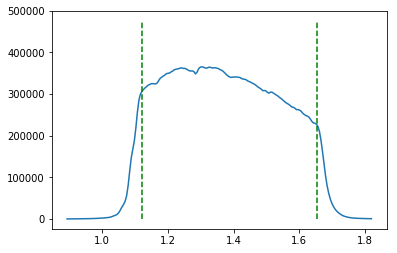

In [4]:
w1 = 1.12
w2 = 1.655
firstspec = df_sorted[Wave].iloc[1]
plt.plot(Wave, firstspec)
plt.plot([w1, w1], [np.min(firstspec), 1.3*np.max(firstspec)], '--', color='g')
plt.plot([w2, w2], [np.min(firstspec), 1.3*np.max(firstspec)], '--', color='g')
plt.show()

Now select the correct wavelengths for a white light curve. What does our white light curve look like?

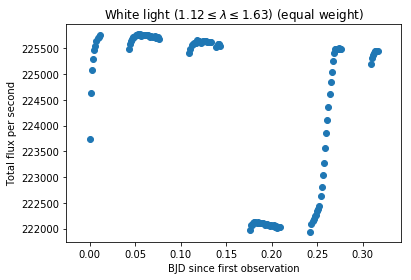

Estimated photon noise: 34.78866530017128 ppm
3.497811347144783e-05


In [5]:
Wavelengthrange = (Wave > w1) & (Wave < w2)
Whitelight_LC, Whitelight_errors = fit_fns.calc_WL(df_sorted, df_sorted_err, Wave[Wavelengthrange]) #np.array(np.sum(df_sorted[Wave[Wavelengthrange]], axis=1))
Whitelight_LC, Whitelight_errors = Whitelight_LC  / imagesize, Whitelight_errors  / imagesize
plt.scatter(sorted_times, Whitelight_LC)
plt.xlabel('BJD since first observation')
plt.ylabel('Total flux per second')
plt.title('White light ($1.12 \leq \lambda \leq 1.63$) (equal weight)')
plt.show()
print "Estimated photon noise:", 1. / np.sqrt(np.mean(Whitelight_LC *imagesize * exptime)) * 1.e6, "ppm"
print np.mean(Whitelight_errors)/ np.mean(Whitelight_LC)

Now we need to divide our data into orbits.

In [6]:
#Define what the first, second, third, forth, fifth and sixth orbit are
Fir = np.arange(0,10)
Sec = np.arange(10,38)
Thi = np.arange(38,62)
For = np.arange(62,90)
Fif = np.arange(90,118)
Six = np.arange(118,125)

Ex_Fir_orbit = np.concatenate((Sec, Thi, For, Fif, Six))

Orbits = [Fir, Sec, Thi, For, Fif, Six]
Orbit_times = []
for i,o in enumerate(Orbits):
    Orbit_start = sorted_times[o[0]] - 1.e-6
    if i < len(Orbits) - 1:
        Orbit_end = sorted_times[Orbits[i+1][0]] - 1.e-6
    else:
        Orbit_end = sorted_times[-1] + 1.e-6
    Orbit_times.append([Orbit_start, Orbit_end])
    
    
#Which orbits are out of transit and could be used for a divide-out-of-transit?
Out_of_transit = np.concatenate((Fir, Sec, Thi, Six))
excl_First = np.concatenate((Sec, Thi, For, Fif, Six))


Forwardscanned = np.array(df_sorted['Forward'] == True)

df_F = df_sorted[Forwardscanned]
df_F_err = df_sorted_err[Forwardscanned]
df_R = df_sorted[~Forwardscanned]
df_R_err = df_sorted_err[~Forwardscanned]


Out_of_transit_F = []
Out_of_transit_R = []
Excl_First = np.zeros(len(sorted_times), dtype=bool)
for i in np.arange(len(sorted_times)):
    if Forwardscanned[i] and i in Out_of_transit and i not in Fir:
        Out_of_transit_F.append(i)
    if not Forwardscanned[i] and i in Out_of_transit and i not in Fir:
        Out_of_transit_R.append(i)
    if i in excl_First:
        Excl_First[i] = True
        
Out_of_transit_F = np.array(Out_of_transit_F)
Out_of_transit_R = np.array(Out_of_transit_R)

# Data visualization

Let's visualize the data with tags of image names

In [7]:
f_i = np.array(np.mean(df_sorted[Wave[Wavelengthrange]], axis=1) / imagesize)
f_i_err = np.array(np.mean(df_sorted_err[Wave[Wavelengthrange]], axis=1) / imagesize / np.sqrt(len(Wavelengthrange)))
#Let's normalize the data to have the data ~1 outside of transit
f_i_full, f_i_full_err = f_i.copy(), f_i_err.copy()
f_i_err /= np.max(f_i)
f_i /= np.max(f_i)

source = ColumnDataSource(data=dict(times=sorted_times,
                                    flux=f_i,
                                    labels=df_sorted['Names']))

output_notebook()
p = figure()
p.scatter(x='times', y='flux', source=source)
labels = LabelSet(x='times', y='flux', text='labels', level='glyph', x_offset=5, y_offset=5, source=source, render_mode='canvas', text_font_size='8px')
p.add_layout(labels)
show(p)

Loading BokehJS ...

# Fitting with a ramp model

## White light fitting

Let's fit a white light curve to the data

Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 13
    # data points      = 115
    # variables        = 9
    chi-square         = 1.1931e-06
    reduced chi-square = 1.1256e-08
    Akaike info crit   = -2096.14755
    Bayesian info crit = -2071.44316
[[Variables]]
    depth_F:                  0.01479820 +/- 2.8095e-05 (0.19%) (init = 0.0016)
    depth_R:                  0.01479820 +/- 2.8095e-05 (0.19%) == 'depth_F'
    Mid_transit_time_offset:  0.00756292 +/- 1.0284e-04 (1.36%) (init = 0)
    Inclination:              86.71 (fixed)
    Eccentricity:             0 (fixed)
    aRs:                      8.79798737 +/- 0.01245413 (0.14%) (init = 8.76)
    u1:                       0.26706662 +/- 0.00893078 (3.34%) (init = 0.28)
    u2:                       0 (fixed)
    Phase_offset:             0 (fixed)
    V2_F:                    -0.00498200 +/- 1.5653e-04 (3.14%) (init = -0.003)
    V2_R:                    -0.00498200 +/- 1.5

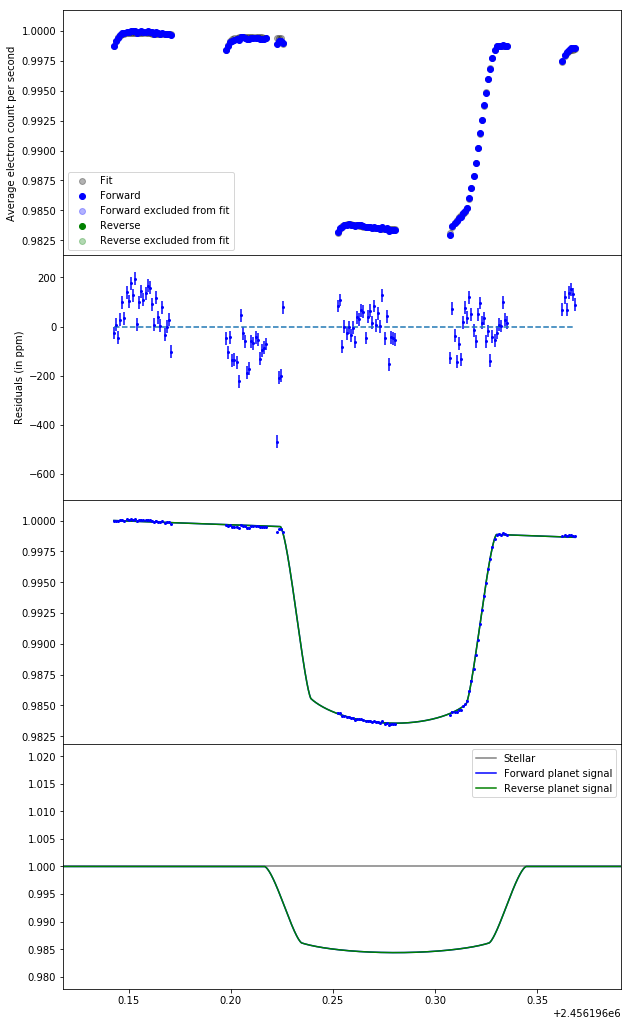

residuals on fitted data in ppm 102.22010270264933
Estimated photon noise: 34.7945390155181 ppm


In [8]:
reload(fit_fns)

Planet_LC = fit_fns.Planet('HD209458')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
Excl_first

opt, err, chi2, bic = Planet_LC.Fit_with_exponential_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           f_i[Excl_first], f_i_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime,
                                                           Transit=True)

fit_opt = opt[:-3]
LC_new = Planet_LC.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i[Excl_first]**2.) / len(f_i[Excl_first])) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full[Excl_first] * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i[Excl_first]**2.) / len(f_i[Excl_first])) *1.e6







We need to fix some parameters that will be shared among each color bin: deltat and a/Rs 

In [9]:
deltat = opt[2]
aRs = opt[5]

## In bins (spectrum) 

Now we'll bin the white lightcurve into bins of 5 pixels (can be adjusted)

In [10]:
Nr_pixels = 5
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

cm = plt.cm.get_cmap('RdYlGn')
colors = cm(np.arange(N_bins)  * cm.N / N_bins)

In [11]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('HD209458')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False


RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []



for i,wave_bin in enumerate(bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c = Planet_LC_multi.Fit_with_exponential_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC[Excl_first], Binned_LC_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, 
                                                           verbose=False,
                                                           Transit=True)
    RpRs2.append(opt_c[0])
    RpRs2_err.append(err_c[0])
    opt_cs.append(opt_c)
    err_cs.append(err_c)
    
    fit_opt = opt_c[:-3]
    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC[Excl_first] - LC_new)**2./ Binned_LC[Excl_first]**2.) / len(Binned_LC[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)


RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)






In [12]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('HD209458')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False


RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []



for i,wave_bin in enumerate(bins):
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c = Planet_LC_multi.Fit_with_exponential_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC[Excl_first], Binned_LC_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, 
                                                           verbose=False,
                                                           Transit=True)
    RpRs2.append(opt_c[0])
    RpRs2_err.append(err_c[0])
    opt_cs.append(opt_c)
    err_cs.append(err_c)
    
    fit_opt = opt_c[:-3]
    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC[Excl_first] - LC_new)**2./ Binned_LC[Excl_first]**2.) / len(Binned_LC[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)


RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)







Text(0.5,0,'Wavelength (microns)')

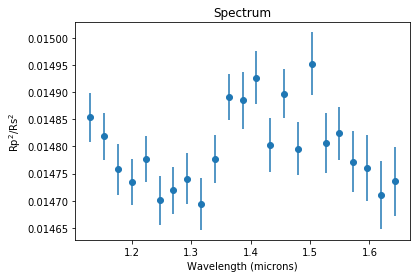

In [13]:
#You can load in a previous spectrum:
#base_wave, base, base_err = np.genfromtxt('KELT-9b_spectrum.txt').T
#if you have Forward and reverse scanned data you can do:
#eds_total, eds_total_err = fit_fns.arithmic_mean(np.array([RpRs_c_F, RpRs_c_R]), 
#                                                 np.array([RpRs_c_F_err, RpRs_c_R_err]), 
#                                                 axis=0, weighted=True)


#plt.errorbar(bins_avg_wave, eds_total, eds_total_err, fmt='o')
#plt.errorbar(base_wave, base, base_err, fmt='o', color='k', alpha=0.3)

#But now we only do a forward scanned spectrum:
plt.errorbar(bins_avg_wave, RpRs2, RpRs2_err, fmt='o')

plt.title('Spectrum')
plt.ylabel('Rp$^2$/Rs$^2$')
plt.xlabel('Wavelength (microns)')

# Fitting with an RECTE model

We can also try fitting with an RECTE model (Zhou et al. 2017). This enables us to also fit for the first orbit (this could be important for establishing the baseline).

## Fitting the white lightcurve 

This time we'll exclude the last few points of the third orbit. We do this by adding the exc_indices parameter. These points are still plot, but they aren't used for fitting.

Fitting a transit


/Users/bob/Documents/PhD/hstscan/RECTE/RECTE.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  obsCounts[i] = f_i * exptime - dE1_s - dE1_f


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 121
    # variables        = 11
    chi-square         = 3.47014391
    reduced chi-square = 0.03154676
    Akaike info crit   = -407.742932
    Bayesian info crit = -376.989236
[[Variables]]
    depth_F:                  0.01465973 +/- 5.7652e-05 (0.39%) (init = 0.0016)
    depth_R:                  0.01465973 +/- 5.7652e-05 (0.39%) == 'depth_F'
    Mid_transit_time_offset:  0.00568500 +/- 6.4819e-04 (11.40%) (init = 0)
    Inclination:              86.71 (fixed)
    Eccentricity:             0 (fixed)
    aRs:                      8.97817576 +/- 0.06828973 (0.76%) (init = 8.76)
    u1:                       0.12102015 +/- 0.06600755 (54.54%) (init = 0.28)
    u2:                       0.26882023 +/- 0.10919436 (40.62%) (init = 0)
    Phase_offset:             0 (fixed)
    V2_F:                    -0.00500665 +/- 1.2194e-04 (2.44%) (init = -0.003)
    V2_R:                  

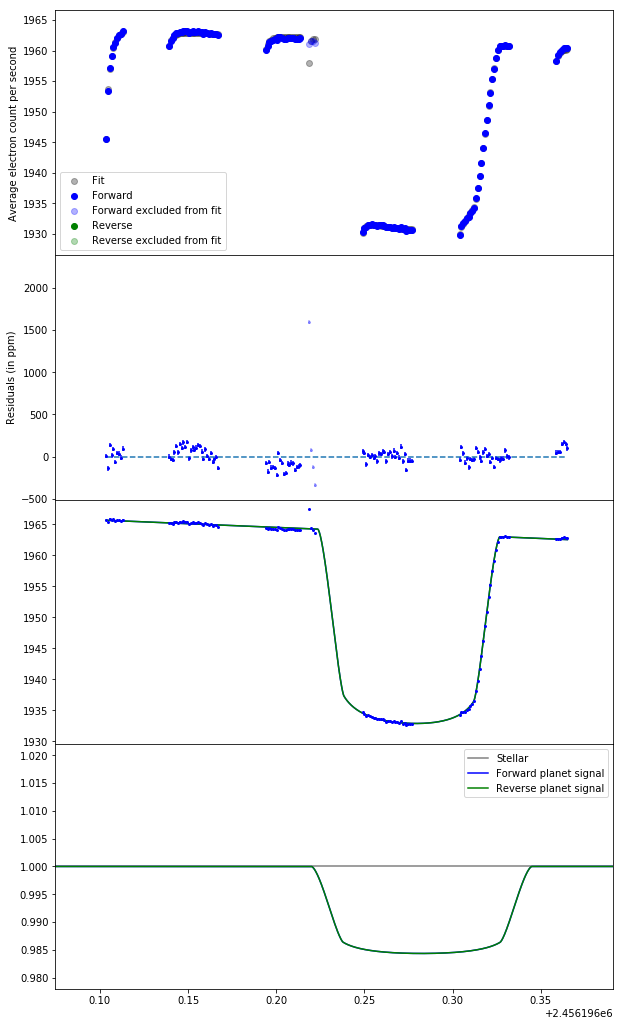

residuals on fitted data in ppm 169.285780473759
Estimated photon noise: 34.78866530017128 ppm


In [8]:
reload(fit_fns)

Planet_LC = fit_fns.Planet('HD209458')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False

opt, err, chi2, bic = Planet_LC.Fit_with_recte_lmfit(sorted_times + min(Times_org), 
                                                           f_i_full, f_i_full_err, 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned, 
                                                           fix_limb_dark=False, limb_dark='quadratic', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime, 
                                                           exc_indices=[58, 59, 60, 61],
                                                           Transit=True)

fit_opt = opt[:-3]
LC_new = Planet_LC.func(sorted_times + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned,
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array,
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((f_i_full - LC_new)**2./ f_i_full**2.) / len(f_i_full)) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise = np.sqrt(np.sum((f_i - LC_new)**2./ f_i_full**2.) / len(f_i_full)) *1.e6







However, sometimes even RECTE won't fit that first orbit. So, you also simply remove that first orbit. RECTE will still work!

Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 16
    # data points      = 115
    # variables        = 11
    chi-square         = 13.3999316
    reduced chi-square = 0.12884550
    Akaike info crit   = -225.213491
    Bayesian info crit = -195.019237
[[Variables]]
    depth_F:                  0.01468744 +/- 1.1533e-04 (0.79%) (init = 0.0016)
    depth_R:                  0.01468744 +/- 1.1533e-04 (0.79%) == 'depth_F'
    Mid_transit_time_offset:  0.00558952 +/- 0.00126659 (22.66%) (init = 0)
    Inclination:              86.71 (fixed)
    Eccentricity:             0 (fixed)
    aRs:                      8.98660079 +/- 0.13362861 (1.49%) (init = 8.76)
    u1:                       0.14255272 +/- 0.13374465 (93.82%) (init = 0.28)
    u2:                       0.24189299 +/- 0.21955747 (90.77%) (init = 0)
    Phase_offset:             0 (fixed)
    V2_F:                    -0.00487285 +/- 2.8422e-04 (5.83%) (init = -0.003)
    V2_R:

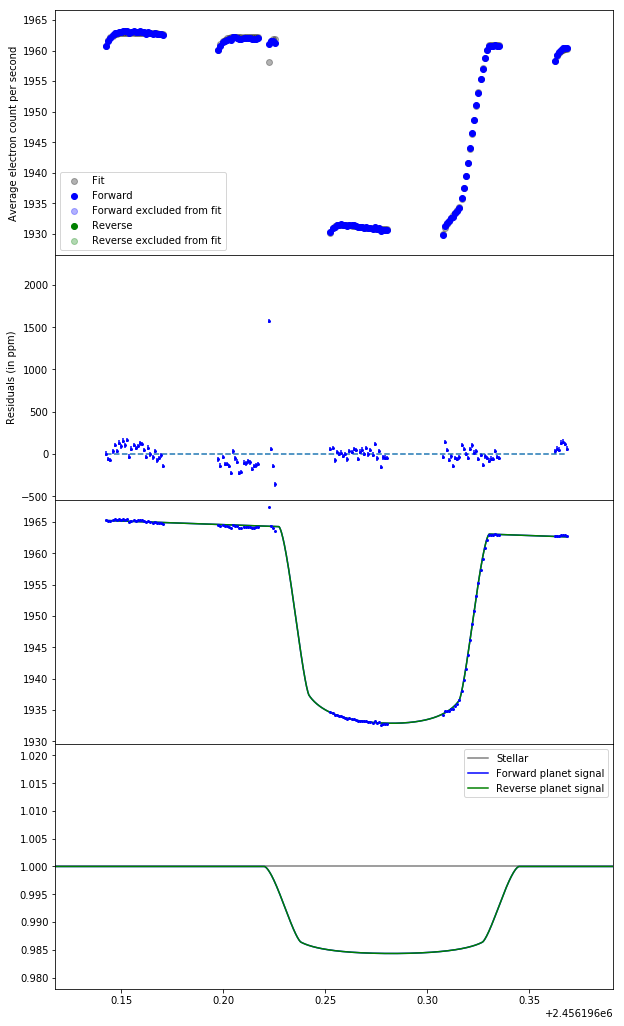

residuals on fitted data in ppm 174.1744883841886
Estimated photon noise: 34.7945390155181 ppm


In [15]:
reload(fit_fns)

Planet_LC = fit_fns.Planet('HD209458')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False

opt, err, chi2, bic = Planet_LC.Fit_with_recte_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           f_i_full[Excl_first], f_i_full_err[Excl_first], 
                                                           np.array(Orbit_times)[1:] + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='quadratic', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime, 
                                                           Transit=True)

fit_opt = opt[:-3]
LC_new = Planet_LC.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array,
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((f_i_full[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full[Excl_first] * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise_g_F = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6
noise_g_R = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6









And now excluding the second orbit + those pesky extra points after the third orbit. This is a good comparison to Tsiaras 2016

Fitting a transit
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 16
    # data points      = 83
    # variables        = 11
    chi-square         = 1.43789536
    reduced chi-square = 0.01997077
    Akaike info crit   = -314.619790
    Bayesian info crit = -288.012543
[[Variables]]
    depth_F:                  0.01453694 +/- 4.8414e-05 (0.33%) (init = 0.0016)
    depth_R:                  0.01453694 +/- 4.8414e-05 (0.33%) == 'depth_F'
    Mid_transit_time_offset:  0.00325820 +/- 3.2273e-04 (9.91%) (init = 0)
    Inclination:              86.71 (fixed)
    Eccentricity:             0 (fixed)
    aRs:                      9.25106633 +/- 0.03541571 (0.38%) (init = 8.76)
    u1:                       1.5229e-14 +/- 0.05538934 (363700059511448.56%) (init = 0.28)
    u2:                       0.48196456 +/- 0.08722251 (18.10%) (init = 0)
    Phase_offset:             0 (fixed)
    V2_F:                    -0.00432911 +/- 1.8238e-04 (4.21%) (init = -0.003

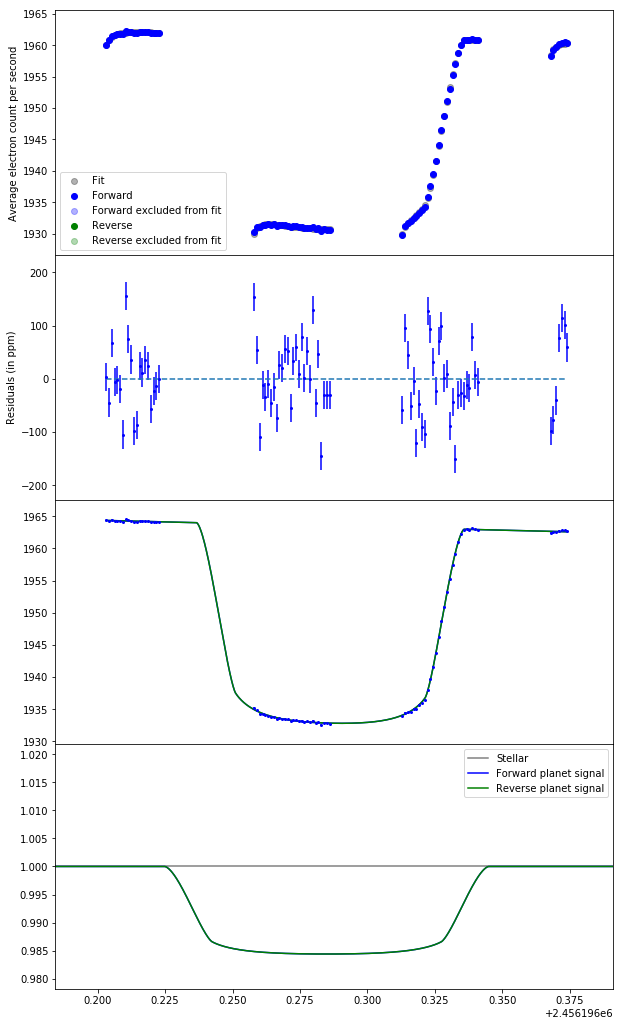

residuals on fitted data in ppm 67.67906513652713
Estimated photon noise: 34.83609355047241 ppm


In [16]:
reload(fit_fns)

Planet_LC = fit_fns.Planet('HD209458')
t0 = Planet_LC.sp_params.t0
while t0 < min(Times_org) + Planet_LC.sp_params.per:
    t0 += Planet_LC.sp_params.per
t0 -= 2 * Planet_LC.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
Excl_first[Sec] = False
Excl_first[58:62] = False

opt, err, chi2, bic = Planet_LC.Fit_with_recte_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           f_i_full[Excl_first], f_i_full_err[Excl_first], 
                                                           np.array(Orbit_times)[2:] + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='quadratic', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, fix_aRs=False,
                                                           nosat=True,
                                                           t0=t0, exptime = exptime, 
                                                           Transit=True)

fit_opt = opt[:-3]
LC_new = Planet_LC.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array,
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]




print "residuals on fitted data in ppm",np.sqrt(np.sum((f_i_full[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6
print "Estimated photon noise:", 1. / np.sqrt(np.mean(f_i_full[Excl_first] * np.sum(Wavelengthrange) * imagesize * exptime)) * 1.e6, "ppm"

noise_g_F = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6
noise_g_R = np.sqrt(np.sum((f_i[Excl_first] - LC_new)**2./ f_i_full[Excl_first]**2.) / len(f_i_full[Excl_first])) *1.e6










In [19]:
deltat = opt[2]
aRs = opt[5]

## Spectrum 

And with RECTE, too, you can make a spectrum. It is important to remember that RECTE was designed for use with single columns. So, it will perform better the smaller your bins are. However, the smaller your bins, the more difficult it is to fit them.

In [20]:
Nr_pixels = 5
bins = []
i = 0
WL_waves = Wave[(Wave > w1) & (Wave < w2)]#Wave[Wavelengthrange]
while i < len(WL_waves):
    bins.append(WL_waves[i:i+Nr_pixels])
    i += Nr_pixels
bins_avg_wave = [np.mean(bin) for bin in bins]

N_bins = len(bins_avg_wave)

cm = plt.cm.get_cmap('RdYlGn')
colors = cm(np.arange(N_bins)  * cm.N / N_bins)

In [36]:
reload(fit_fns)
Planet_LC_multi = fit_fns.Planet('HD209458')
t0 = Planet_LC_multi.sp_params.t0
while t0 < min(Times_org) + Planet_LC_multi.sp_params.per:
    t0 += Planet_LC_multi.sp_params.per
t0 -= 2 * Planet_LC_multi.sp_params.per


Excl_first = np.ones_like(sorted_times, dtype=bool)
Excl_first[Fir] = False
Excl_first[Sec] = False
Excl_first[58:62] = False


RpRs2 = []
RpRs2_err = []
opt_cs = []
err_cs = []
noise = []
photonnoise = []



for i,wave_bin in enumerate(bins):
    #if i !=10: continue
    Binned_LC, Binned_LC_err = fit_fns.calc_WL(df_sorted, df_sorted_err, wave_bin, average=True, weighted=False)
    Binned_LC = Binned_LC / imagesize
    Binned_LC_err = Binned_LC_err / imagesize
    Binned_LC_full, Binned_LC_full_err = Binned_LC.copy(), Binned_LC_err.copy()
    Binned_LC_err /= np.max(Binned_LC)
    Binned_LC /= np.max(Binned_LC)
    opt_c, err_c, chi2_c, bic_c = Planet_LC_multi.Fit_with_recte_lmfit(sorted_times[Excl_first] + min(Times_org), 
                                                           Binned_LC_full[Excl_first], Binned_LC_full_err[Excl_first], 
                                                           np.array(Orbit_times) + min(Times_org), 
                                                           Forwardscanned[Excl_first], 
                                                           fix_limb_dark=False, limb_dark='linear', 
                                                           fix_inclination=True, 
                                                           fix_eccentricity=True, 
                                                           nosat=True,
                                                           deltat=deltat, a=aRs, fix_aRs=True,
                                                           t0=t0, exptime = exptime, 
                                                           verbose=False,
                                                           Transit=True)
    RpRs2.append(opt_c[0])
    RpRs2_err.append(err_c[0])
    opt_cs.append(opt_c)
    err_cs.append(err_c)

    fit_opt = opt_c[:-3]
    LC_new = Planet_LC_multi.func(sorted_times[Excl_first] + min(Times_org), *fit_opt,
                                                                          Forward=Forwardscanned[Excl_first],
                                                                          sp_params=Planet_LC.sp_params,
                                                                          orbit_times=Planet_LC.orbit_times,
                                                                          satellite_time=Planet_LC.satellite_time,
                                                                          Include=Planet_LC.exc_array, 
                                                                          exptime=exptime,
                                                                          noexcl=Planet_LC.noexcl,
                                                                          Stel_puls_phase=opt[-3],
                                                                          Stel_puls_amp=opt[-2], Harm_amp=opt[-1],
                                                                          fit=False)[0]


    noise.append(np.sqrt(np.sum((Binned_LC_full[Excl_first] - LC_new)**2./ Binned_LC_full[Excl_first]**2.) / len(Binned_LC_full[Excl_first])) *1.e6)
    photonnoise.append(1. / np.sqrt(np.mean(Binned_LC_full[Excl_first] * len(wave_bin) * imagesize * exptime)) * 1.e6)


RpRs2 = np.array(RpRs2)
RpRs2_err = np.array(RpRs2_err)







Text(0.5,0,'Wavelength (microns)')

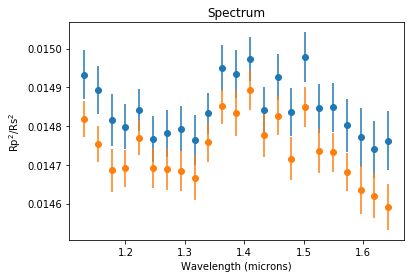

In [28]:
#You can load in a previous spectrum:
#base_wave, base, base_err = np.genfromtxt('KELT-9b_spectrum.txt').T
#if you have Forward and reverse scanned data you can do:
#eds_total, eds_total_err = fit_fns.arithmic_mean(np.array([RpRs_c_F, RpRs_c_R]), 
#                                                 np.array([RpRs_c_F_err, RpRs_c_R_err]), 
#                                                 axis=0, weighted=True)


#plt.errorbar(bins_avg_wave, eds_total, eds_total_err, fmt='o')
#plt.errorbar(base_wave, base, base_err, fmt='o', color='k', alpha=0.3)

#But now we only do a forward scanned spectrum:
plt.errorbar(bins_avg_wave, RpRs2, RpRs2_err, fmt='o')
plt.errorbar(bins_avg_wave, RpRs2_, RpRs2_err_, fmt='o')

plt.title('Spectrum')
plt.ylabel('Rp$^2$/Rs$^2$')
plt.xlabel('Wavelength (microns)')

In [26]:
RpRs2_, RpRs2_err_ = RpRs2, RpRs2_err

In [35]:
np.mean(RpRs2_err)

6.264591698787991e-05

In [34]:
np.array(noise) / np.array(photonnoise)

array([1.51160709, 1.5191719 , 1.70495409, 1.50516123, 1.41188117,
       1.53166671, 1.56291209, 1.52445333, 1.68689661, 1.38079986,
       1.52055547, 1.55591606, 1.4455927 , 1.51839249, 1.46272825,
       1.49633793, 1.52521636, 1.49715925, 1.46671881, 1.55972485,
       1.68459116, 1.59378922, 1.5895908 ])

In [25]:
photonnoise

[169.21602495177797,
 166.50310234136478,
 163.50071366457198,
 160.39907515398022,
 158.3132928264115,
 157.66655472325547,
 159.01096967481737,
 158.46463267036842,
 157.2310427291712,
 157.4369260781317,
 158.794187874044,
 162.0178678662289,
 162.53423948052674,
 163.80295576391885,
 165.96637181566064,
 169.1681426514382,
 171.53373759180465,
 173.21847920713097,
 177.33812440735412,
 181.61412885526204,
 185.06801180585288,
 189.79619805828722,
 196.30799616957728]

In [20]:
opt_cs

[[0.014877663719144249,
  0.014877663719144249,
  0.007562923544402811,
  86.71,
  0.0,
  8.797987367020415,
  0.30570790312010493,
  0.0,
  0.0,
  -0.0061886728748009445,
  -0.0061886728748009445,
  1916.1860578088872,
  1916.1860578088872,
  1295.3158171328705,
  120.75534264855357,
  94.68165839698682,
  116.03640272202392,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.014836678573003984,
  0.014836678573003984,
  0.007562923544402811,
  <Parameter 'Inclination', value=86.71 (fixed), bounds=[-inf:inf]>,
  <Parameter 'Eccentricity', value=0.0 (fixed), bounds=[-inf:inf]>,
  8.797987367020415,
  0.31407432337713587,
  0.0,
  0.0,
  -0.0041041568676476285,
  -0.0041041568676476285,
  1978.3858718432455,
  1978.3858718432455,
  1377.4823843800632,
  101.17753446990645,
  82.30195842022546,
  114.9352306610388,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.01477093467894682,
  0.01477093467894682,
  0.007562923544402811,
  <Parameter 'Inclination', value=<Par

We need to ensure ourselves that all fitted parameters are well inside the ranges and that they are not driven to one of the extremes (i.e. 0 or the red dashed line in the coming plots).

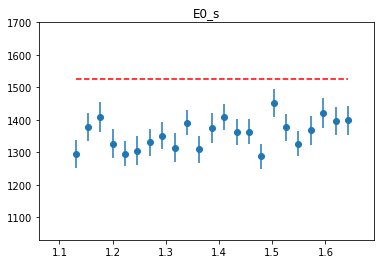

In [22]:
fig = plt.figure()
plt.plot([bins_avg_wave[0], bins_avg_wave[-1]], [1525.38, 1525.38], '--', color='r')
plt.errorbar(bins_avg_wave, np.array(opt_cs)[:,13], yerr=np.array(err_cs)[:,13], fmt='o')
plt.title('E0_s')
plt.gca().set_xlim(0.94*bins_avg_wave[0], bins_avg_wave[-1]*1.03)
plt.gca().set_ylim(0.8*np.min(np.array(opt_cs)[:,13]), 1700)
plt.show()

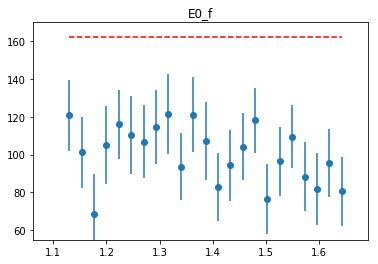

In [25]:
fig = plt.figure()
plt.plot([bins_avg_wave[0], bins_avg_wave[-1]], [162.38, 162.38], '--', color='r')
plt.errorbar(bins_avg_wave, np.array(opt_cs)[:,14], yerr=np.array(err_cs)[:,14], fmt='o')
plt.title('E0_f')
plt.gca().set_xlim(0.94*bins_avg_wave[0], bins_avg_wave[-1]*1.03)
plt.gca().set_ylim(0.8*np.min(np.array(opt_cs)[:,14]), 170)
plt.show()

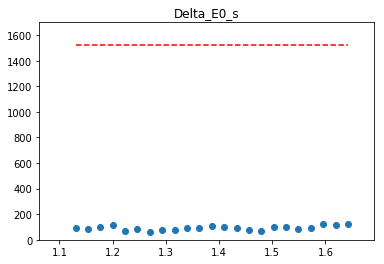

In [28]:
#This one may be relatively low, but if they're lower than 1, that's wrong.
fig = plt.figure()
plt.plot([bins_avg_wave[0], bins_avg_wave[-1]], [1525.38, 1525.38], '--', color='r')
plt.errorbar(bins_avg_wave, np.array(opt_cs)[:,15], yerr=np.array(err_cs)[:,15], fmt='o')
plt.title('Delta_E0_s')
plt.gca().set_xlim(0.94*bins_avg_wave[0], bins_avg_wave[-1]*1.03)
plt.gca().set_ylim(0, 1700)
plt.show()

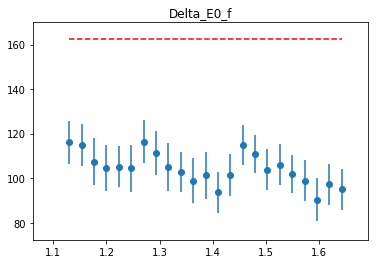

In [29]:
fig = plt.figure()
plt.plot([bins_avg_wave[0], bins_avg_wave[-1]], [162.38, 162.38], '--', color='r')
plt.errorbar(bins_avg_wave, np.array(opt_cs)[:,16], yerr=np.array(err_cs)[:,16], fmt='o')
plt.title('Delta_E0_f')
plt.gca().set_xlim(0.94*bins_avg_wave[0], bins_avg_wave[-1]*1.03)
plt.gca().set_ylim(0.8*np.min(np.array(opt_cs)[:,16]), 170)
plt.show()